# Normalizing Flows Powered Neural Posterior Estimation for Strong Gravitational Lensing

In [143]:
# Torch
import torch
from torch.utils.data import DataLoader
from torch.distributions import Normal, Uniform

# SBI
from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.utils import BoxUniform, MultipleIndependent
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding

# Others
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import corner


In [147]:
def update_figure_legend(fig, color, legend_label, lw = 2, fontsize = 20):

    # Retrieve old handles & labels if they exist
    old_handles = getattr(fig, '_my_legend_handles', [])
    old_labels = getattr(fig, '_my_legend_labels', [])

    # Remove any existing figure-level legends (if present)
    if hasattr(fig, 'legends') and fig.legends:
        for legend in fig.legends:
            legend.remove()

    # Create a new handle
    new_handle = plt.Line2D([0], [0], color=color, lw=lw)

    # Append new handle & label
    old_handles.append(new_handle)
    old_labels.append(legend_label)

    # Save them back onto the figure object
    fig._my_legend_handles = old_handles
    fig._my_legend_labels = old_labels

    # Draw a fresh single legend containing all handles/labels so far
    fig.legend(
        handles=fig._my_legend_handles,
        labels=fig._my_legend_labels,
        loc='upper right',
        fontsize=fontsize,
        frameon=False
    )

def plot_corner(samples, truths, labels, color, legend_label=None):

    if labels is None:
        labels = [
            r'$\theta_\mathrm{E}$', r'$\gamma_1$', r'$\gamma_2$', 
            r'$\gamma_\mathrm{lens}$', r'$e_1$', r'$e_2$', 
            r'$x_\mathrm{lens}$', r'$y_\mathrm{lens}$', 
            r'$x_\mathrm{src}$', r'$y_\mathrm{src}$'
        ]

    fig = corner.corner(
        np.array(samples),
        labels=labels,
        truths=truths,
        show_titles=True,
        title_fmt='.2f',
        title_kwargs=dict(fontsize=15),
        label_kwargs=dict(fontsize=20),
        truth_color='k',
        levels=[0.68, 0.95],
        bins=20,
        plot_datapoints=False,
        fill_contours=True,
        max_n_ticks=3,
        smooth=1.0,
        hist_kwargs=dict(density=True, color=color, linewidth=2, histtype='step'),
        color=color,
        fig=None
    )
    
    # Delegate legend creation to our helper
    update_figure_legend(fig, color, legend_label=legend_label)

    return fig
    
def plot_corner_overlay(samples, fig, color, legend_label=None):

    fig = corner.corner(
        np.array(samples),
        levels=[0.68, 0.95],
        bins=20,
        plot_datapoints=False,
        fill_contours=True,
        max_n_ticks=3,
        smooth=1.0,
        hist_kwargs=dict(density=True, color=color, linewidth=2, histtype='step'),
        color=color,
        fig=fig
    )
    
    # Delegate legend update to our helper
    update_figure_legend(fig, color, legend_label=legend_label)

    return fig

### 1. Data Processing

In [131]:
# === Load Image Data ===

# Function to load image data
def load_image_data(file_path: str) -> torch.Tensor:
    with h5py.File(file_path, 'r') as f:
        data = f["data"][:] 
    data_tensor = torch.tensor(data, dtype=torch.float32)
    return data_tensor

# Load data x 
file_path = "../data/image_data.h5"  
x = load_image_data(file_path)
print("Loaded Image Data Shape:", x.shape)

# === Load Parameter Labels ===

# Function to load parameter labels
def load_parameter_labels(file_path: str, keep_columns: list) -> torch.Tensor:
    parameters = pd.read_csv(file_path)
    parameters = parameters[keep_columns]
    parameters_tensor = torch.tensor(parameters.values, dtype=torch.float32)
    return parameters_tensor

# Load parameters theta
file_path = "../data/metadata.csv"
keep_columns = [
    "main_deflector_parameters_theta_E",
    "main_deflector_parameters_gamma1",
    "main_deflector_parameters_gamma2",
    "main_deflector_parameters_gamma",
    "main_deflector_parameters_e1",
    "main_deflector_parameters_e2",
    "main_deflector_parameters_center_x",
    "main_deflector_parameters_center_y",
    "source_parameters_center_x",
    "source_parameters_center_y"
    ]
parameter_labels = [r'$\theta_\mathrm{E}$',r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_\mathrm{lens}$',r'$e_1$',r'$e_2$']
param_labels = [r'$\theta_\mathrm{E}$',r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_\mathrm{lens}$',r'$e_1$',
								r'$e_2$',r'$x_\mathrm{lens}$',r'$y_\mathrm{lens}$',r'$x_\mathrm{src}$',r'$y_\mathrm{src}$']
theta = load_parameter_labels(file_path, keep_columns)
print("Loaded Parameter Labels Shape:", theta.shape)
                       

Loaded Image Data Shape: torch.Size([10000, 165, 165])
Loaded Parameter Labels Shape: torch.Size([10000, 10])


### 2. Neural Network Architecture

In [6]:
# === Define Neural Network ===

# Define embedding network
embedding_net = CNNEmbedding(
    input_shape=(165, 165),
    in_channels=1,
    out_channels_per_layer=[32, 64],  # More filters for better feature extraction
    num_conv_layers=2,
    num_linear_layers=2,
    output_dim=64,
    kernel_size=3,
    pool_kernel_size=4
)

embedding_net = CNNEmbedding(
    input_shape=(165, 165),
    in_channels=1,
    out_channels_per_layer=[32],  # More filters for better feature extraction
    num_conv_layers=1,
    num_linear_layers=1,
    output_dim=32,
    kernel_size=3,
    pool_kernel_size=4
)

# think about embedding first etc.

# Define density estimator
# density_estimator_build_fun = posterior_nn(
#     model="nsf", hidden_features=10, num_transforms=3, embedding_net=embedding_net # 60 # 3
# )
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=5, num_transforms=5, embedding_net=embedding_net # 60 # 3
)

# Define inference object (NPE)
inference = NPE(density_estimator=density_estimator_build_fun)




### 3. Training

In [7]:
# === Training ===

# Pass simulated data to inference object
inference = inference.append_simulations(theta, x)

# Train the density estimator
density_estimator = inference.train()

# Build the posterior
posterior = inference.build_posterior(density_estimator)
print(posterior)

 Neural network successfully converged after 69 epochs.Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


### 5. Inference

In [8]:
# how to split the data into training and validation
x_test = x[0:1000]
theta_test = theta[0:1000]
x_train = x[1000:]
theta_train = theta[1000:]

In [128]:
# === Inference ===

# Define observed data
x_obs = x[0:100]

medians = []
stds = []
for i in range(10):
    # Sample from the posterior
    samples = posterior.sample((1000,), x=x_obs[0])
    samples2 = posterior.sample((1000,), x=x_obs[10])
    samples3 = posterior.sample((1000,), x=x_obs[2])

    # Compute the median and standard deviation
    median = samples.median(dim=0).values
    std = samples.std(dim=0).values

    medians.append(median)
    stds.append(std)

# medians = torch.stack(medians)
# stds = torch.stack(stds)


# Sample learned posterior
samples = posterior.sample((10000,), x=x_obs[0])
# _ = pairplot(samples, figsize=(12, 12))



Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 68290.23it/s]


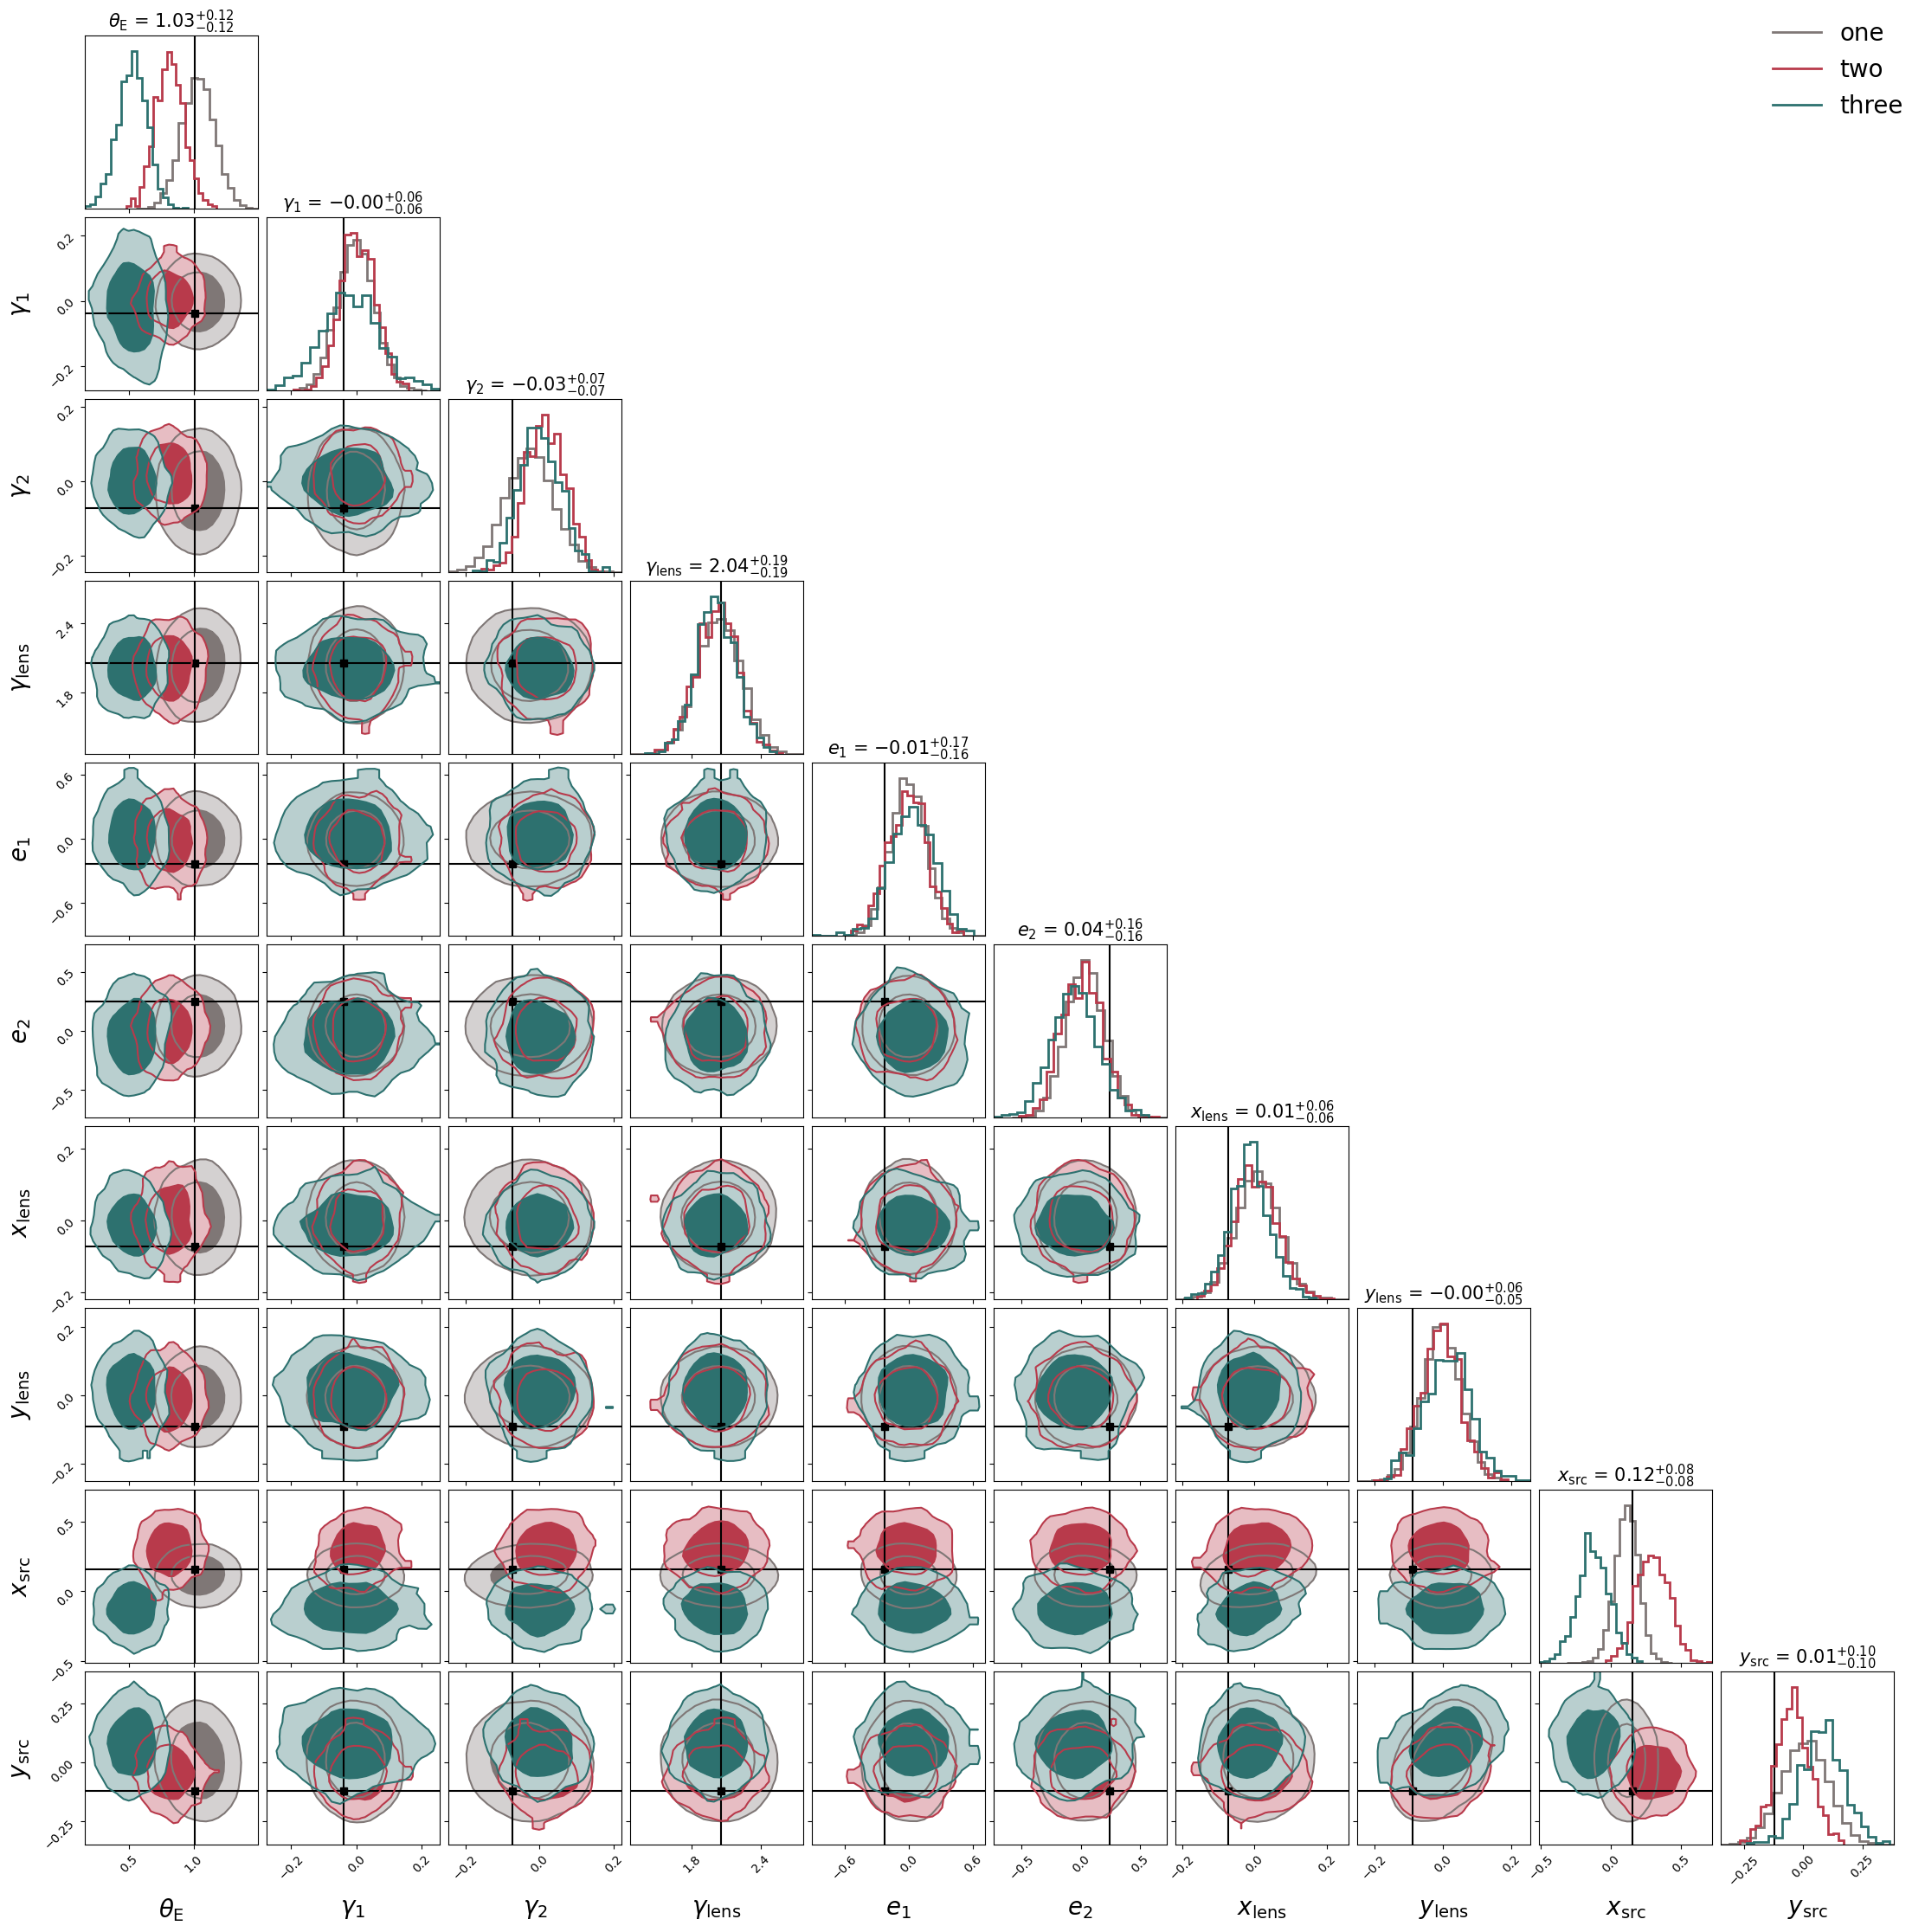

In [151]:
# Corner plot function
import corner
import matplotlib.pyplot as plt

samples

stanford_red = '#8C1515'
stanford_red_light = '#B83A4B'
stanford_green = '#175E54'
stanford_green_light = '#2D716F'
stanford_grey = '#53565A'
stanford_brown = '#5D4B3C'
stanford_brown_light ='#766253'
stanford_stone = '#7F7776'
stanford_fog = '#DAD7CB'


# Plot corner plot
truths = theta_test[0]

f = plot_corner(np.array(samples), truths, param_labels, stanford_stone, 'one')
f = plot_corner_overlay(np.array(samples2), f, stanford_red_light, 'two')
f = plot_corner_overlay(np.array(samples3), f, stanford_green_light, 'three')
plt.show()